In [1]:
%reset -f

In [2]:
#!pip install ../input/python-datatable/datatable-0.11.0-cp37-cp37m-manylinux2010_x86_64.whl > /dev/null 2>&1

In [3]:
import pandas as pd
import numpy as np
import gc
from sklearn.metrics import roc_auc_score
from collections import defaultdict
from tqdm.notebook import tqdm
import lightgbm as lgb
import pickle
#import dill as pickle

import matplotlib.pyplot as plt
import seaborn as sns


import random
import os

In [4]:
# Random seed
SEED = 2020

# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(SEED)

In [5]:
def save_obj(obj, name):
    with open(name + '.pkl',mode = 'wb') as f:
        pickle.dump(obj, f)

In [6]:
def question_df(df):
    #Carga de questions
    columnas = ['question_id','part', 'bundle_id']
    dtypes={'question_id': 'int16', 'part': 'uint8', 'bundle_id': 'uint8'}
    questions = pd.read_csv('../input/riiid-test-answer-prediction/questions.csv', usecols = columnas, dtype = dtypes)
    return pd.merge(df, questions, left_on = 'content_id', right_on = 'question_id', how = 'left')

In [7]:
def actualizar_features_inicio(df, features_dicts):
    
    for num, row in enumerate(tqdm(df[['user_id', 'answered_correctly', 'content_id', 'prior_question_elapsed_time', 'prior_question_had_explanation', 'timestamp','mean_question_accuracy']].itertuples(), total=df.shape[0])):
        features_dicts['cont_preguntas_user'][row.user_id] += 1
        features_dicts['elapsed_time_u_sum'][row.user_id] += row.prior_question_elapsed_time
        features_dicts['explanation_u_sum'][row.user_id] += row.prior_question_had_explanation
        if len(features_dicts['timestamp_u'][row.user_id]) == 3:
            features_dicts['timestamp_u'][row.user_id].pop(0)
            features_dicts['timestamp_u'][row.user_id].append(row.timestamp)
        else:
            features_dicts['timestamp_u'][row.user_id].append(row.timestamp)
        # ------------------------------------------------------------------
        # Question features updates
        features_dicts['cont_preguntas'][row.content_id] += 1
        features_dicts['elapsed_time_q_sum'][row.content_id] += row.prior_question_elapsed_time
        features_dicts['explanation_q_sum'][row.content_id] += row.prior_question_had_explanation
        # ------------------------------------------------------------------
        # User Question updates
        features_dicts['intentos_dict'][row.user_id][row.content_id] += 1
        # ------------------------------------------------------------------
        # ------------------------------------------------------------------
        # User features updates
        features_dicts['cont_preguntas_corr_user'][row.user_id] += row.answered_correctly
        if row.answered_correctly == 0:
            features_dicts['timestamp_u_incorrect'][row.user_id] = row.timestamp
        # ------------------------------------------------------------------
        # Question features updates
        features_dicts['cont_preguntas_corr'][row.content_id] += row.answered_correctly
        #actualizacion ELO
        features_dicts['CUMULATIVE_ELO_USER'][row.user_id] += (1 - row.mean_question_accuracy)*100

In [8]:
def añadir_features(df, features_dicts):
    
    #Usuario
    tasa_acierto_usuario = np.zeros(len(df), dtype = np.float32)
    elapsed_time_u_avg = np.zeros(len(df), dtype = np.float32)
    explanation_u_avg = np.zeros(len(df), dtype = np.float32)
    user_pause_timestamp_1 = np.zeros(len(df), dtype = np.float32)
    user_pause_timestamp_2 = np.zeros(len(df), dtype = np.float32)
    user_pause_timestamp_3 = np.zeros(len(df), dtype = np.float32)
    user_pause_timestamp_incorrect = np.zeros(len(df), dtype = np.float32)
    cont_preguntas_corr_user_f = np.zeros(len(df), dtype = np.int16)
    cont_preguntas_user_f = np.zeros(len(df), dtype = np.int16)
    CUMULATIVE_ELO_USER = np.zeros(len(df), dtype = np.int32)
    # -----------------------------------------------------------------------
    # Question features
    tasa_acierto_pregunta = np.zeros(len(df), dtype = np.float32)
    elapsed_time_q_avg = np.zeros(len(df), dtype = np.float32)
    explanation_q_avg = np.zeros(len(df), dtype = np.float32)
    # -----------------------------------------------------------------------
    # User Question
    intentos = np.zeros(len(df), dtype = np.int16)
    
    for num, row in enumerate(tqdm(df[['user_id', 'answered_correctly', 'content_id', 'prior_question_elapsed_time', 'prior_question_had_explanation', 'timestamp','mean_question_accuracy']].itertuples(), total=df.shape[0])):
        
        #ELO
        CUMULATIVE_ELO_USER[num] = features_dicts['CUMULATIVE_ELO_USER'][row.user_id]
        
        # User features
        # ------------------------------------------------------------------
        if features_dicts['cont_preguntas_user'][row.user_id] != 0:
            tasa_acierto_usuario[num] = features_dicts['cont_preguntas_corr_user'][row.user_id] / features_dicts['cont_preguntas_user'][row.user_id]
            elapsed_time_u_avg[num] = features_dicts['elapsed_time_u_sum'][row.user_id] / features_dicts['cont_preguntas_user'][row.user_id]
            explanation_u_avg[num] = features_dicts['explanation_u_sum'][row.user_id] / features_dicts['cont_preguntas_user'][row.user_id]
            cont_preguntas_corr_user_f[num] = features_dicts['cont_preguntas_corr_user'][row.user_id]
            cont_preguntas_user_f[num] = features_dicts['cont_preguntas_user'][row.user_id]
            
        else:
            tasa_acierto_usuario[num] = np.nan
            elapsed_time_u_avg[num] = np.nan
            explanation_u_avg[num] = np.nan
            cont_preguntas_corr_user_f[num] = 0
            cont_preguntas_user_f[num] = 0

            
        if len(features_dicts['timestamp_u'][row.user_id]) == 0:
            user_pause_timestamp_1[num] = np.nan
            user_pause_timestamp_2[num] = np.nan
            user_pause_timestamp_3[num] = np.nan
        elif len(features_dicts['timestamp_u'][row.user_id]) == 1:
            user_pause_timestamp_1[num] = row.timestamp - features_dicts['timestamp_u'][row.user_id][0]
            user_pause_timestamp_2[num] = np.nan
            user_pause_timestamp_3[num] = np.nan
        elif len(features_dicts['timestamp_u'][row.user_id]) == 2:
            user_pause_timestamp_1[num] = row.timestamp - features_dicts['timestamp_u'][row.user_id][1]
            user_pause_timestamp_2[num] = row.timestamp - features_dicts['timestamp_u'][row.user_id][0]
            user_pause_timestamp_3[num] = np.nan
        elif len(features_dicts['timestamp_u'][row.user_id]) == 3:
            user_pause_timestamp_1[num] = row.timestamp - features_dicts['timestamp_u'][row.user_id][2]
            user_pause_timestamp_2[num] = row.timestamp - features_dicts['timestamp_u'][row.user_id][1]
            user_pause_timestamp_3[num] = row.timestamp - features_dicts['timestamp_u'][row.user_id][0]
        
        user_pause_timestamp_incorrect[num] = row.timestamp - features_dicts['timestamp_u_incorrect'][row.user_id]
          
        # ------------------------------------------------------------------
        # Question features assignation
        if features_dicts['cont_preguntas'][row.content_id] != 0:
            tasa_acierto_pregunta[num] = features_dicts['cont_preguntas_corr'][row.content_id] / features_dicts['cont_preguntas'][row.content_id]
            elapsed_time_q_avg[num] = features_dicts['elapsed_time_q_sum'][row.content_id] / features_dicts['cont_preguntas'][row.content_id]
            explanation_q_avg[num] = features_dicts['explanation_q_sum'][row.content_id] / features_dicts['cont_preguntas'][row.content_id]
        else:
            tasa_acierto_pregunta[num] = np.nan
            elapsed_time_q_avg[num] = np.nan
            explanation_q_avg[num] = np.nan
        # ------------------------------------------------------------------
        # User Question assignation
        intentos[num] = features_dicts['intentos_dict'][row.user_id][row.content_id]
        
        # ------------------------------------------------------------------
        # ------------------------------------------------------------------
        # Actualizaciones
        features_dicts['cont_preguntas_user'][row.user_id] += 1
        features_dicts['elapsed_time_u_sum'][row.user_id] += row.prior_question_elapsed_time
        features_dicts['explanation_u_sum'][row.user_id] += row.prior_question_had_explanation
        if len(features_dicts['timestamp_u'][row.user_id]) == 3:
            features_dicts['timestamp_u'][row.user_id].pop(0)
            features_dicts['timestamp_u'][row.user_id].append(row.timestamp)
        else:
            features_dicts['timestamp_u'][row.user_id].append(row.timestamp)
        # ------------------------------------------------------------------
        # Question features updates
        features_dicts['cont_preguntas'][row.content_id] += 1
        features_dicts['elapsed_time_q_sum'][row.content_id] += row.prior_question_elapsed_time
        features_dicts['explanation_q_sum'][row.content_id] += row.prior_question_had_explanation
        # ------------------------------------------------------------------
        # User Question updates
        features_dicts['intentos_dict'][row.user_id][row.content_id] += 1
        # ------------------------------------------------------------------
        # ------------------------------------------------------------------
        # User features updates
        features_dicts['cont_preguntas_corr_user'][row.user_id] += row.answered_correctly
        if row.answered_correctly == 0:
            features_dicts['timestamp_u_incorrect'][row.user_id] = row.timestamp
        # ------------------------------------------------------------------
        # Question features updates
        features_dicts['cont_preguntas_corr'][row.content_id] += row.answered_correctly

        #actualizacion ELO
        features_dicts['CUMULATIVE_ELO_USER'][row.user_id] += (1 - row.mean_question_accuracy)*100
        
    #print('  - Bucle de features finalizado')
    
    user_df = pd.DataFrame({'%_acierto_usuario': tasa_acierto_usuario, 'elapsed_time_u_avg': elapsed_time_u_avg, 'explanation_u_avg': explanation_u_avg, 
                            '%_acierto_pregunta_CONT': tasa_acierto_pregunta, 'elapsed_time_q_avg': elapsed_time_q_avg, 'explanation_q_avg': explanation_q_avg, 
                            'intentos': intentos, 'user_pause_timestamp_1': user_pause_timestamp_1, 'user_pause_timestamp_2': user_pause_timestamp_2,
                            'user_pause_timestamp_3': user_pause_timestamp_3, 'user_pause_timestamp_incorrect': user_pause_timestamp_incorrect,
                            'cont_preguntas_corr_user':cont_preguntas_corr_user_f, 'cont_preguntas_user': cont_preguntas_user_f, 'CUMULATIVE_ELO_USER':CUMULATIVE_ELO_USER}) 
    
    
    del tasa_acierto_usuario, cont_preguntas_user_f,CUMULATIVE_ELO_USER, cont_preguntas_corr_user_f, elapsed_time_u_avg, explanation_u_avg, tasa_acierto_pregunta, elapsed_time_q_avg, explanation_q_avg, intentos, user_pause_timestamp_1,  user_pause_timestamp_2,user_pause_timestamp_3, user_pause_timestamp_incorrect
 
    df = pd.concat([df, user_df], axis = 1)
    del user_df
    
    #features extra
    df['correction'] = (df['user_pause_timestamp_1'] + 1) / (df['user_pause_timestamp_incorrect'] + 1) + df['prior_question_had_explanation'] + df['intentos']
    df['user_pause_timestamp_ratio_1'] = (df['user_pause_timestamp_1'] + 1)/ (df['user_pause_timestamp_2'] + 1)
    df['%_media_armonica'] = 2*df['%_acierto_usuario']*df['mean_question_accuracy']/(df['%_acierto_usuario'] + df['mean_question_accuracy'])
    df['%_media_armonica'].fillna(0.642673913, inplace = True)

    df['user_pause_timestamp_MEAN_RATIO'] = df['user_pause_timestamp_1']/((df['user_pause_timestamp_1'] + df['user_pause_timestamp_2'] + df['user_pause_timestamp_3'])/3 + 1)
    df['ELO'] = (df['CUMULATIVE_ELO_USER'] + 4*df['user_pause_timestamp_MEAN_RATIO']*(2*df['cont_preguntas_corr_user'] - df['cont_preguntas_user'])) / df['cont_preguntas_user']
    df['expected_prob'] = 1 / (1 + 9**(((1 - df['mean_question_accuracy']) * 100 - df['ELO'])/15))

    df.replace(np.inf, 0, inplace = True)
    df[['ELO','correction','user_pause_timestamp_ratio_1','%_media_armonica','user_pause_timestamp_MEAN_RATIO','expected_prob']] = df[['ELO','correction','user_pause_timestamp_ratio_1','%_media_armonica','user_pause_timestamp_MEAN_RATIO','expected_prob']].astype(np.float32)
    
    
    #df['noise'] = np.random.normal(0, 1, len(df)).astype(np.float32)
    
    return df

In [9]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype
    if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)                    
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                    df[col] = df[col].astype(np.uint64)
            elif str(col_type)[:5] == 'float':
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [10]:
def preprocesamiento():
    
    print('LECTURA INICIADA')
    train_pickle = '../input/riiid-cross-validation-files/cv1_train.pickle'
    valid_pickle = '../input/riiid-cross-validation-files/cv1_valid.pickle'
    
    columnas = ['timestamp', 'user_id', 'answered_correctly', 'content_id', 'content_type_id', 'prior_question_elapsed_time', 'prior_question_had_explanation']
    train = pd.read_pickle(train_pickle)[columnas]
    valid = pd.read_pickle(valid_pickle)[columnas]
    
    #eliminacion de lectures
    train = train.loc[train.content_type_id == False].reset_index(drop = True)
    valid = valid.loc[valid.content_type_id == False].reset_index(drop = True)
    
    #Limpieza
    train['prior_question_had_explanation'] = train['prior_question_had_explanation'].fillna(False).astype('int8')
    valid['prior_question_had_explanation'] = valid['prior_question_had_explanation'].fillna(False).astype('int8')
    
    prior_question_elapsed_time_mean = train['prior_question_elapsed_time'].dropna().values.mean()
    train['prior_question_elapsed_time'].fillna(prior_question_elapsed_time_mean, inplace = True)
    valid['prior_question_elapsed_time'].fillna(prior_question_elapsed_time_mean, inplace = True)
    
    print('Prior_question_elapsed_time_mean = ',prior_question_elapsed_time_mean)
    

    train = train[-40000000:]
    print('LECTURA FINALIZADA')
    
    
    #Añadimos question features
    train = question_df(train)
    valid = question_df(valid)
    
    #QUESTIONS MEAN
    columnas = ['content_id','mean_question_accuracy','std_accuracy']
    dtypes={'content_id': 'int16', 'mean_question_accuracy': 'float32', 'std_accuracy': 'float32'}
    questions = pd.read_csv('../input/question-csv-riiid/question_metadata.csv', usecols = columnas, dtype = dtypes)

    
    train = train.merge(questions, on = 'content_id', how='left')
    valid = valid.merge(questions, on = 'content_id', how='left')
    
    
    print('')
    
    #Reducimos memoria para evitar errores
    train = reduce_mem_usage(train)
    print('')
    valid = reduce_mem_usage(valid)
    print('')
    
    #Creamos dicionarios
    features_dicts = {
        'cont_preguntas_user': defaultdict(int),
        'cont_preguntas_corr_user': defaultdict(int),
        'elapsed_time_u_sum': defaultdict(int),
        'explanation_u_sum': defaultdict(int),
        'cont_preguntas': defaultdict(int),
        'cont_preguntas_corr': defaultdict(int),
        'elapsed_time_q_sum': defaultdict(int),
        'explanation_q_sum': defaultdict(int),
        'intentos_dict': defaultdict(lambda: defaultdict(int)),
        'timestamp_u': defaultdict(list),
        'timestamp_u_incorrect': defaultdict(int),
        'CUMULATIVE_ELO_USER': defaultdict(int)}
    
    print('PROCESAMIENTO DE FEATURES INICIADO')
    print('\n')
    
    train = añadir_features(train, features_dicts)
    gc.collect()
    
    valid = añadir_features(valid, features_dicts)
    
    #Reducimos memoria para evitar errores
    train = reduce_mem_usage(train)
    valid = reduce_mem_usage(valid)
    print('')
    gc.collect()
    
    
    print('PROCESAMIENTO DE FEATURES FINALIZADO')
    print('\n')
    
    return train, valid, features_dicts, prior_question_elapsed_time_mean

In [11]:
def entrenamiento(train, valid, features_dicts, feature_engineering = False):
    TARGET = 'answered_correctly'

    FEATURES = ['prior_question_elapsed_time', '%_acierto_usuario', 'elapsed_time_u_avg', 'explanation_u_avg',
                '%_acierto_pregunta_CONT', 'elapsed_time_q_avg', 'explanation_q_avg', 'user_pause_timestamp_1', 'user_pause_timestamp_2', 
                'user_pause_timestamp_3', 'user_pause_timestamp_incorrect','%_media_armonica', 'cont_preguntas_user', 
                'cont_preguntas_corr_user' ,'correction', 'user_pause_timestamp_ratio_1', 'bundle_id','mean_question_accuracy','std_accuracy',  
                'ELO','CUMULATIVE_ELO_USER', 'user_pause_timestamp_MEAN_RATIO','expected_prob', 'part', 'intentos', 'prior_question_had_explanation', 'content_id'] 
    #, 'noise', 'part', 'intentos', 'prior_question_had_explanation', 'content_id'
    
    #Eliminacion de features
    if feature_engineering:
        train = train.sample(15000000, random_state = SEED)
        
    gc.collect()
    print(f'Traning with {train.shape[0]} rows and {len(FEATURES)} features')
    
    #Eliminamos columnas innecesarias
    drop_cols = list(set(train.columns) - set(FEATURES))
    y_train = train[TARGET]
    y_val = valid[TARGET]
    # Drop unnecessary columns
    train.drop(drop_cols, axis = 1, inplace = True)
    valid.drop(drop_cols, axis = 1, inplace = True)
    gc.collect()
    
    lgb_train = lgb.Dataset(train[FEATURES], y_train)
    lgb_valid = lgb.Dataset(valid[FEATURES], y_val)
    
    del train, y_train
    gc.collect()
    
    params = {'num_leaves': 350,
          'max_bin':700,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.7,
          #'bagging_fraction': 0.58,
          #'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.05,
          'boosting_type': "gbdt",
          'bagging_seed': 11,
          #'bagging_freq': 1,
          'metric': 'auc',
          #'verbosity': -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47}
    
    model = lgb.train(
        params = params,
        train_set = lgb_train,
        num_boost_round = 350,#esta en 10000, voy a probar con 350(overfitting)
        valid_sets = [lgb_train, lgb_valid],
        early_stopping_rounds = 10,
        verbose_eval = 50)
    
    print('Roc Auc score for the validation data is:', roc_auc_score(y_val, model.predict(valid[FEATURES])))
    
    del lgb_train, lgb_valid, y_val, valid
    gc.collect()
    
    model.save_model('model_1.txt')
    
    feature_importance = model.feature_importance()
    feature_importance = pd.DataFrame({'Features': FEATURES, 'Importance': feature_importance}).sort_values('Importance', ascending = False)
    
    fig = plt.figure(figsize = (10, 10))
    fig.suptitle('Feature Importance', fontsize = 20)
    plt.tick_params(axis = 'x', labelsize = 12)
    plt.tick_params(axis = 'y', labelsize = 12)
    plt.xlabel('Importance', fontsize = 15)
    plt.ylabel('Features', fontsize = 15)
    sns.barplot(x = feature_importance['Importance'], y = feature_importance['Features'], orient = 'h')
    plt.show()
    
    return TARGET, FEATURES

LECTURA INICIADA
Prior_question_elapsed_time_mean =  25439.41
LECTURA FINALIZADA

Memory usage of dataframe is 1564.03 MB
Memory usage after optimization is: 1487.73 MB
Decreased by 4.9%

Memory usage of dataframe is 95.95 MB
Memory usage after optimization is: 91.27 MB
Decreased by 4.9%

PROCESAMIENTO DE FEATURES INICIADO





Memory usage of dataframe is 4310.61 MB
Memory usage after optimization is: 4234.31 MB
Decreased by 1.8%
Memory usage of dataframe is 264.44 MB
Memory usage after optimization is: 259.76 MB
Decreased by 1.8%

PROCESAMIENTO DE FEATURES FINALIZADO


Traning with 15000000 rows and 27 features
Training until validation scores don't improve for 10 rounds
[50]	training's auc: 0.777397	valid_1's auc: 0.780437
[100]	training's auc: 0.781164	valid_1's auc: 0.783719
[150]	training's auc: 0.7834	valid_1's auc: 0.785483
[200]	training's auc: 0.784933	valid_1's auc: 0.786534
[250]	training's auc: 0.785903	valid_1's auc: 0.787021
[300]	training's auc: 0.78661	valid_1's auc: 0.787235
[350]	training's auc: 0.78732	valid_1's auc: 0.787473
Did not meet early stopping. Best iteration is:
[350]	training's auc: 0.78732	valid_1's auc: 0.787473
Roc Auc score for the validation data is: 0.7874729594258948


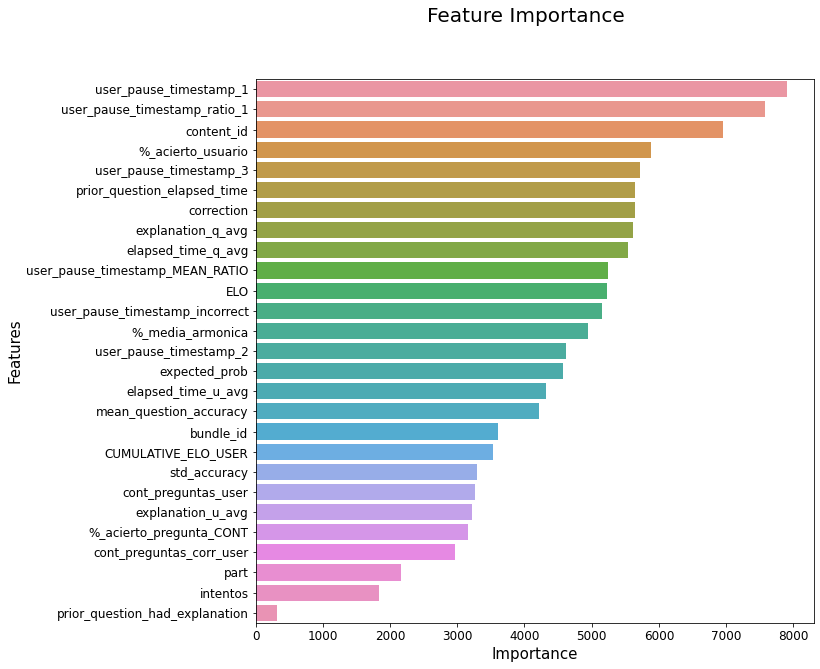

In [12]:
#Main
train, valid, features_dicts, prior_question_elapsed_time_mean = preprocesamiento()
TARGET, FEATURES = entrenamiento(train, valid, features_dicts, feature_engineering = True)

#Guardamos
save_obj(TARGET, 'TARGET')
save_obj(FEATURES, 'FEATURES')
save_obj(prior_question_elapsed_time_mean, 'prior_question_elapsed_time_mean')